In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import pandas as pd
import random
import time
import csv
from datetime import datetime
import pytz
tz = pytz.timezone('Europe/Berlin')
import seaborn as sns
import platform

In [25]:
x = np.asarray([1, 2, 1, 2, 1.5])
y = np.asarray([1, 1, 2, 2, 1.5])
z = np.asarray([10, 15, -2, 2, 0])

In [26]:
gridrez = 5

In [27]:
def create_ranges(start, stop, N, endpoint=True):
    if endpoint==1:
        divisor = N-1
    else:
        divisor = N
    steps = (1.0/divisor) * (stop - start)
    return steps[:,None]*np.arange(N) + start[:,None]

def linspace_nd(x,y,gridrez):
    a1 = create_ranges(x.min(axis=1), x.max(axis=1), N=gridrez, endpoint=True)
    a2 = create_ranges(y.min(axis=1), y.max(axis=1), N=gridrez, endpoint=True)
    out_shp = a1.shape + (a2.shape[1],)
    Xout = np.broadcast_to(a1[:,None,:], out_shp)
    Yout = np.broadcast_to(a2[:,:,None], out_shp)
    return Xout, Yout

def stacked_lstsq(L, b, rcond=1e-10):
    """
    Solve L x = b, via SVD least squares cutting of small singular values
    L is an array of shape (..., M, N) and b of shape (..., M).
    Returns x of shape (..., N)
    """
    u, s, v = np.linalg.svd(L, full_matrices=False)
    s_max = s.max(axis=-1, keepdims=True)
    s_min = rcond*s_max
    inv_s = np.zeros_like(s)
    inv_s[s >= s_min] = 1/s[s>=s_min]
    x = np.einsum('...ji,...j->...i', v,
                  inv_s * np.einsum('...ji,...j->...i', u, b.conj()))
    return np.conj(x, x)

def vectorized_bi2Dlinter(x_vals, y_vals, z_vals, gridrez):

    X,Y = linspace_nd(x_vals, y_vals, gridrez)
    A = np.stack((x_vals,y_vals,np.ones_like(z_vals)), axis=2)
    C = stacked_lstsq(A, z_vals)
    n_bcast = C.shape[0]
    return C.T[0].reshape((n_bcast,1,1))*X + C.T[1].reshape((n_bcast,1,1))*Y + C.T[2].reshape((n_bcast,1,1))

In [28]:
results =  []

for i in range(6):
    for jj in range(100):
        laenge = 10**i

        x1loc = 1.0
        x2loc = 2.0
        x3loc = 1.0
        x4loc = 2.0
        x5loc = 1.5

        y1loc = 1.0
        y2loc = 1.0
        y3loc = 2.0
        y4loc = 2.0
        y5loc = 1.5
        
        
        xxx = x1loc+np.random.rand(laenge)
        
        df2 = pd.DataFrame({"x1":xxx,
                            "x2":x2loc+np.random.rand(laenge),
                            "x3":x3loc+np.random.rand(laenge),
                            "x4":x4loc+np.random.rand(laenge),
                            "x5":x5loc+np.random.rand(laenge),
                            "y1":y1loc+np.random.rand(laenge),
                            "y2":y2loc+np.random.rand(laenge),
                            "y3":y3loc+np.random.rand(laenge),
                            "y4":y4loc+np.random.rand(laenge),
                            "y5":y5loc+np.random.rand(laenge),
                            "z1":np.random.rand(laenge),
                            "z2":np.random.rand(laenge),
                            "z3":np.random.rand(laenge),
                            "z4":np.random.rand(laenge),
                            "z5":np.random.rand(laenge),
                           })

        ZZ = []

        start2 = time.time()
        x_vals = df2[['x1','x2','x3','x4','x5']].values
        y_vals = df2[['y1','y2','y3','y4','y5']].values
        z_vals = df2[['z1','z2','z3','z4','z5']].values

        res = vectorized_bi2Dlinter(x_vals,y_vals,z_vals,gridrez)
        YY = np.mean(np.mean(res, axis=2),axis=1).tolist()
        df2['ZZv']=YY
        end2 = time.time()

        results.append([laenge, end2-start2])

In [29]:
npresults = np.asarray(results)

df = pd.DataFrame(np.asarray(results))
df.columns = ['NumberOfRows', 'execution time']
df['NumberOfRows']  = np.int32(df['NumberOfRows'].values)
df['log(duration)'] = np.log((df['execution time'].values).astype('float'))

[Text(0.5, 0, 'Number of Rows in DataFrame')]

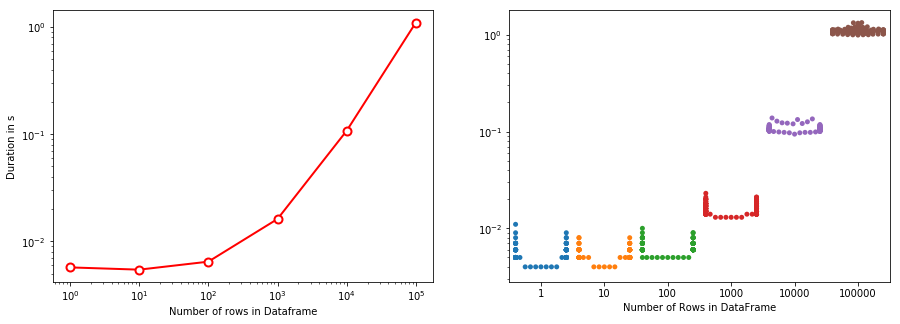

In [30]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1x = list(set(npresults[:,0]))
ax1y = [np.mean(npresults[npresults[:,0]==case, 1]) for case in set(npresults[:,0])]

ax1x, ax1y = zip(*sorted(zip(ax1x, ax1y)))

ax1.plot(ax1x,ax1y, color='red', marker='o', label="vectorized",    markerfacecolor='white', markeredgewidth=2, markeredgecolor='red', markersize=8,  linewidth=2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Number of rows in Dataframe')
ax1.set_ylabel('Duration in s')

sns.swarmplot(x='NumberOfRows',y='execution time', data=df, ax=ax2)
ax2.set_yscale("log") # log first
ax2.set_ylabel('')
ax2.set(xlabel='Number of Rows in DataFrame')

In [23]:
with open('results_'+platform.machine()+'laptop'+(datetime.now(tz)).strftime("%Y%m%d-%H%M%S")+'.csv', 'w', newline='') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(["dfRowCount", "execution time"])
    writer.writerows(results)

csvFile.close()